In [1]:
import os
import subprocess
import urllib.request
import zipfile
import shutil
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import imageio

In [ ]:
# Set random seed
random.seed(42)

DATASET_DIR = "pelvis_smalllll"
OUTPUT_DIR = "pelvis_200"
full_path = os.path.join(os.getcwd(), DATASET_DIR)
full_path = os.path.join(os.getcwd(), OUTPUT_DIR)

# Subfolders for Pix2Pix dataset
styles = ["A", "B", "mask"]  # A for MR, B for CT, mask for segmentation masks
subfolders = ["train", "val", "test"]

# Create output folder structure
for style in styles:
    for subfolder in subfolders:
        os.makedirs(os.path.join(OUTPUT_DIR, style, subfolder), exist_ok=True)

# Function to process and save 2D slices
def process_nii(file_path, output_path_base, axis=2):
    nii = nib.load(file_path)
    data = nii.get_fdata()

    # Normalize data to 0-255 for saving as PNG
    data = 255 * (data - np.min(data)) / (np.max(data) - np.min(data))
    data = data.astype(np.uint8)

    # Calculate the middle slices range
    total_slices = data.shape[axis]
    start_index = max(0, total_slices // 2 - 64)
    end_index = min(total_slices, total_slices // 2 + 64)

    # Save only the middle 200 slices
    for i in range(start_index, end_index):
        slice_data = np.take(data, indices=i, axis=axis)
        output_path = f"{output_path_base}_{i}.png"
        imageio.imwrite(output_path, slice_data)

# Collect all patient folders
patient_folders = [f for f in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, f))]

# Shuffle patient folders for random splitting
random.shuffle(patient_folders)

# Split into train, val, and test sets
num_total = len(patient_folders)
num_train = int(num_total * 0.8)
num_val = int(num_total * 0.1)

train_folders = patient_folders[:num_train]
val_folders = patient_folders[num_train:num_train + num_val]
test_folders = patient_folders[num_train + num_val:]

# Function to process a patient folder and save slices
def process_patient_folder(patient_folder, subset):
    patient_path = os.path.join(DATASET_DIR, patient_folder)

    # Paths for MR, CT, and mask images
    mr_path = os.path.join(patient_path, "mr.nii.gz")
    ct_path = os.path.join(patient_path, "ct.nii.gz")
    mask_path = os.path.join(patient_path, "mask.nii.gz")

    if os.path.exists(mr_path) and os.path.exists(ct_path) and os.path.exists(mask_path):
        # Define base output paths
        mr_output_base = os.path.join(OUTPUT_DIR, "A", subset, patient_folder)
        ct_output_base = os.path.join(OUTPUT_DIR, "B", subset, patient_folder)
        mask_output_base = os.path.join(OUTPUT_DIR, "mask", subset, patient_folder)

        # Process MR, CT, and mask images
        process_nii(mr_path, mr_output_base)
        process_nii(ct_path, ct_output_base)
        process_nii(mask_path, mask_output_base)

# Process train, val, and test sets
for folder in test_folders:
    process_patient_folder(folder, "test")
print("Test data splitting complete")
for folder in val_folders:
    process_patient_folder(folder, "val")
print("Val data splitting complete")
for folder in train_folders:
    process_patient_folder(folder, "train")
print("Train data splitting complete")

print("✅ Dataset conversion and splitting complete!")


Test data splitting complete
Val data splitting complete
Train data splitting complete
✅ Dataset conversion and splitting complete!


In [10]:
print(len(os.listdir("pelvis_200/A/train")))

1024


In [11]:
import os
import glob
from PIL import Image
import torchvision.transforms as transforms

input_root = "pelvis_200"
output_root = "reshaped_200"
full_path = os.path.join(os.getcwd(), input_root)
full_path = os.path.join(os.getcwd(), output_root)
# Folders to process (both A and B)
subfolders = [
    "A/train", "A/val", "A/test",
    "B/train", "B/val", "B/test",
    "mask/train", "mask/val", "mask/test"
]

# Ensure all output directories exist
for subfolder in subfolders:
    os.makedirs(os.path.join(output_root, subfolder), exist_ok=True)

# Function to resize long edge to 256 and pad short edge
def resize_and_pad(img, target_size=256):
    """Resize long edge to target_size, then pad short edge to target_size."""
    w, h = img.size
    scale = target_size / max(w, h)  # Scaling factor to adjust long edge
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize while keeping aspect ratio
    img = img.resize((new_w, new_h), Image.BICUBIC)
    
    # Compute padding values
    delta_w, delta_h = target_size - new_w, target_size - new_h
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
    
    # Apply padding (black background)
    img = transforms.functional.pad(img, padding, fill=0)  # Change fill=255 for white padding
    return img

# Process images in each subfolder
for subfolder in subfolders:
    input_dir = os.path.join(input_root, subfolder)
    output_dir = os.path.join(output_root, subfolder)

    # Get all images
    image_paths = glob.glob(os.path.join(input_dir, "*.png"))  # Change "*.png" if using another format

    for img_path in image_paths:
        img = Image.open(img_path).convert("RGB")  # Convert to RGB mode
        processed_img = resize_and_pad(img, target_size=256)

        # Save to output folder
        output_path = os.path.join(output_dir, os.path.basename(img_path))
        processed_img.save(output_path, "PNG")

        print(f"Processed: {output_path}")

print("!!!!!!!!!!!!!!! All images preprocessed successfully!!!!!!!!!!!!!!!!!!")


Processed: reshaped_200\A/train\1PA005_100.png
Processed: reshaped_200\A/train\1PA005_101.png
Processed: reshaped_200\A/train\1PA005_102.png
Processed: reshaped_200\A/train\1PA005_103.png
Processed: reshaped_200\A/train\1PA005_104.png
Processed: reshaped_200\A/train\1PA005_105.png
Processed: reshaped_200\A/train\1PA005_106.png
Processed: reshaped_200\A/train\1PA005_107.png
Processed: reshaped_200\A/train\1PA005_108.png
Processed: reshaped_200\A/train\1PA005_109.png
Processed: reshaped_200\A/train\1PA005_11.png
Processed: reshaped_200\A/train\1PA005_110.png
Processed: reshaped_200\A/train\1PA005_111.png
Processed: reshaped_200\A/train\1PA005_112.png
Processed: reshaped_200\A/train\1PA005_113.png
Processed: reshaped_200\A/train\1PA005_114.png
Processed: reshaped_200\A/train\1PA005_115.png
Processed: reshaped_200\A/train\1PA005_116.png
Processed: reshaped_200\A/train\1PA005_117.png
Processed: reshaped_200\A/train\1PA005_118.png
Processed: reshaped_200\A/train\1PA005_119.png
Processed: res

In [12]:
print(len(os.listdir("reshaped_200/A/train")))

1024


Train

In [8]:
import os
import cv2
import numpy as np

# 設定資料夾路徑
base_dir = "reshaped_200"
folders = ["train", "test", "val"]

# 輸出資料夾
output_dir = "pix2pix_200_pair"
os.makedirs(output_dir, exist_ok=True)

for folder in folders:
    a_dir = os.path.join(base_dir, "A", folder)
    b_dir = os.path.join(base_dir, "B", folder)
    output_folder = os.path.join(output_dir, folder)
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(a_dir):
        a_path = os.path.join(a_dir, filename)
        b_path = os.path.join(b_dir, filename)

        if os.path.exists(b_path):
            # 讀取圖片
            img_a = cv2.imread(a_path)
            img_b = cv2.imread(b_path)

            # 確保兩張圖片尺寸相同
            if img_a.shape != img_b.shape:
                print(f"尺寸不匹配: {filename}")
                continue
            
            # 左右拼接
            combined = np.hstack((img_a, img_b))

            # 存成新的圖片
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, combined)

print("處理完成，Pix2Pix 資料集已生成！")


處理完成，Pix2Pix 資料集已生成！


In [3]:
print(len(os.listdir("pix2pix_200_pair/train")))

1024


In [1]:
import subprocess

cmd = [
    "c:/Users/User/anaconda3/envs/torch_gpu_env/python", "-u", "train.py",
    "--dataroot", "./pix2pix_200_pair",
    "--name", "pix2pix_200_batch16",
    "--model", "pix2pix",
    "--display_id", "-1",
    "--batch_size", "16",
    "--n_epochs", "100",
    "--n_epochs_decay", "50",
    "--lr", "0.0001",
    "--gan_mode", "lsgan",
    "--lambda_L1", "100.0",
    "--continue_train",
    "--epoch_count", "101"
]

process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, bufsize=1)

# 讀取標準輸出並即時顯示
while True:
    output = process.stdout.readline()
    if output == "" and process.poll() is not None:
        break
    if output:
        print(output.strip(), flush=True)

# 讀取錯誤輸出（如果有錯誤）
while True:
    error_output = process.stderr.readline()
    if error_output == "" and process.poll() is not None:
        break
    if error_output:
        print("ERROR:", error_output.strip(), flush=True)


----------------- Options ---------------
batch_size: 16                            	[default: 1]
beta1: 0.5
checkpoints_dir: ./checkpoints
continue_train: True                          	[default: False]
crop_size: 256
dataroot: ./pix2pix_200_pair            	[default: None]
dataset_mode: aligned
direction: AtoB
display_env: main
display_freq: 400
display_id: -1                            	[default: 1]
display_ncols: 4
display_port: 8097
display_server: http://localhost
display_winsize: 256
epoch: latest
epoch_count: 101                           	[default: 1]
gan_mode: lsgan                         	[default: vanilla]
gpu_ids: 0
init_gain: 0.02
init_type: normal
input_nc: 3
isTrain: True                          	[default: None]
lambda_L1: 100.0
load_iter: 0                             	[default: 0]
load_size: 286
lr: 0.0001                        	[default: 0.0002]
lr_decay_iters: 50
lr_policy: linear
max_dataset_size: inf
model: pix2pix                       	[default: cycle_gan]
n_

Test

In [ ]:
import subprocess

# 指定命令及參數
cmd = [
    "c:/Users/User/anaconda3/envs/torch_gpu_env/python",  # 確保這個環境存在
    "-u", "test.py",
    "--dataroot", "./pix2pix_200_pair",
    "--name", "pix2pix_200_pair",
    "--model", "pix2pix",
    "--num_test", "400",
    "--epoch", "150",
    # "--epoch_end", "275"
]

# 使用 subprocess 啟動外部程序
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, bufsize=1)

# 讀取標準輸出
while True:
    output = process.stdout.readline()
    if output == "" and process.poll() is not None:
        break
    if output:
        print(output.strip(), flush=True)

# 讀取錯誤輸出
while True:
    error_output = process.stderr.readline()
    if error_output == "" and process.poll() is not None:
        break
    if error_output:
        print("ERROR:", error_output.strip(), flush=True)


start!
Testing script started...
----------------- Options ---------------
aspect_ratio: 1.0
batch_size: 1
checkpoints_dir: ./checkpoints
crop_size: 256
dataroot: ./pix2pix_200_pair            	[default: None]
dataset_mode: aligned
direction: AtoB
display_winsize: 256
epoch: 150                           	[default: latest]
epoch_end: 0
epoch_start: 0
eval: False
gpu_ids: 0
init_gain: 0.02
init_type: normal
input_nc: 3
isTrain: False                         	[default: None]
load_iter: 0                             	[default: 0]
load_size: 256
max_dataset_size: inf
model: pix2pix                       	[default: test]
n_layers_D: 3
name: pix2pix_200_pair              	[default: experiment_name]
ndf: 64
netD: basic
netG: unet_256
ngf: 64
no_dropout: False
no_flip: False
norm: batch
num_test: 400                           	[default: 50]
num_threads: 4
output_nc: 3
phase: test
preprocess: resize_and_crop
results_dir: ./results/
serial_batches: False
suffix:
use_wandb: False
verbose: False
w

Visualize

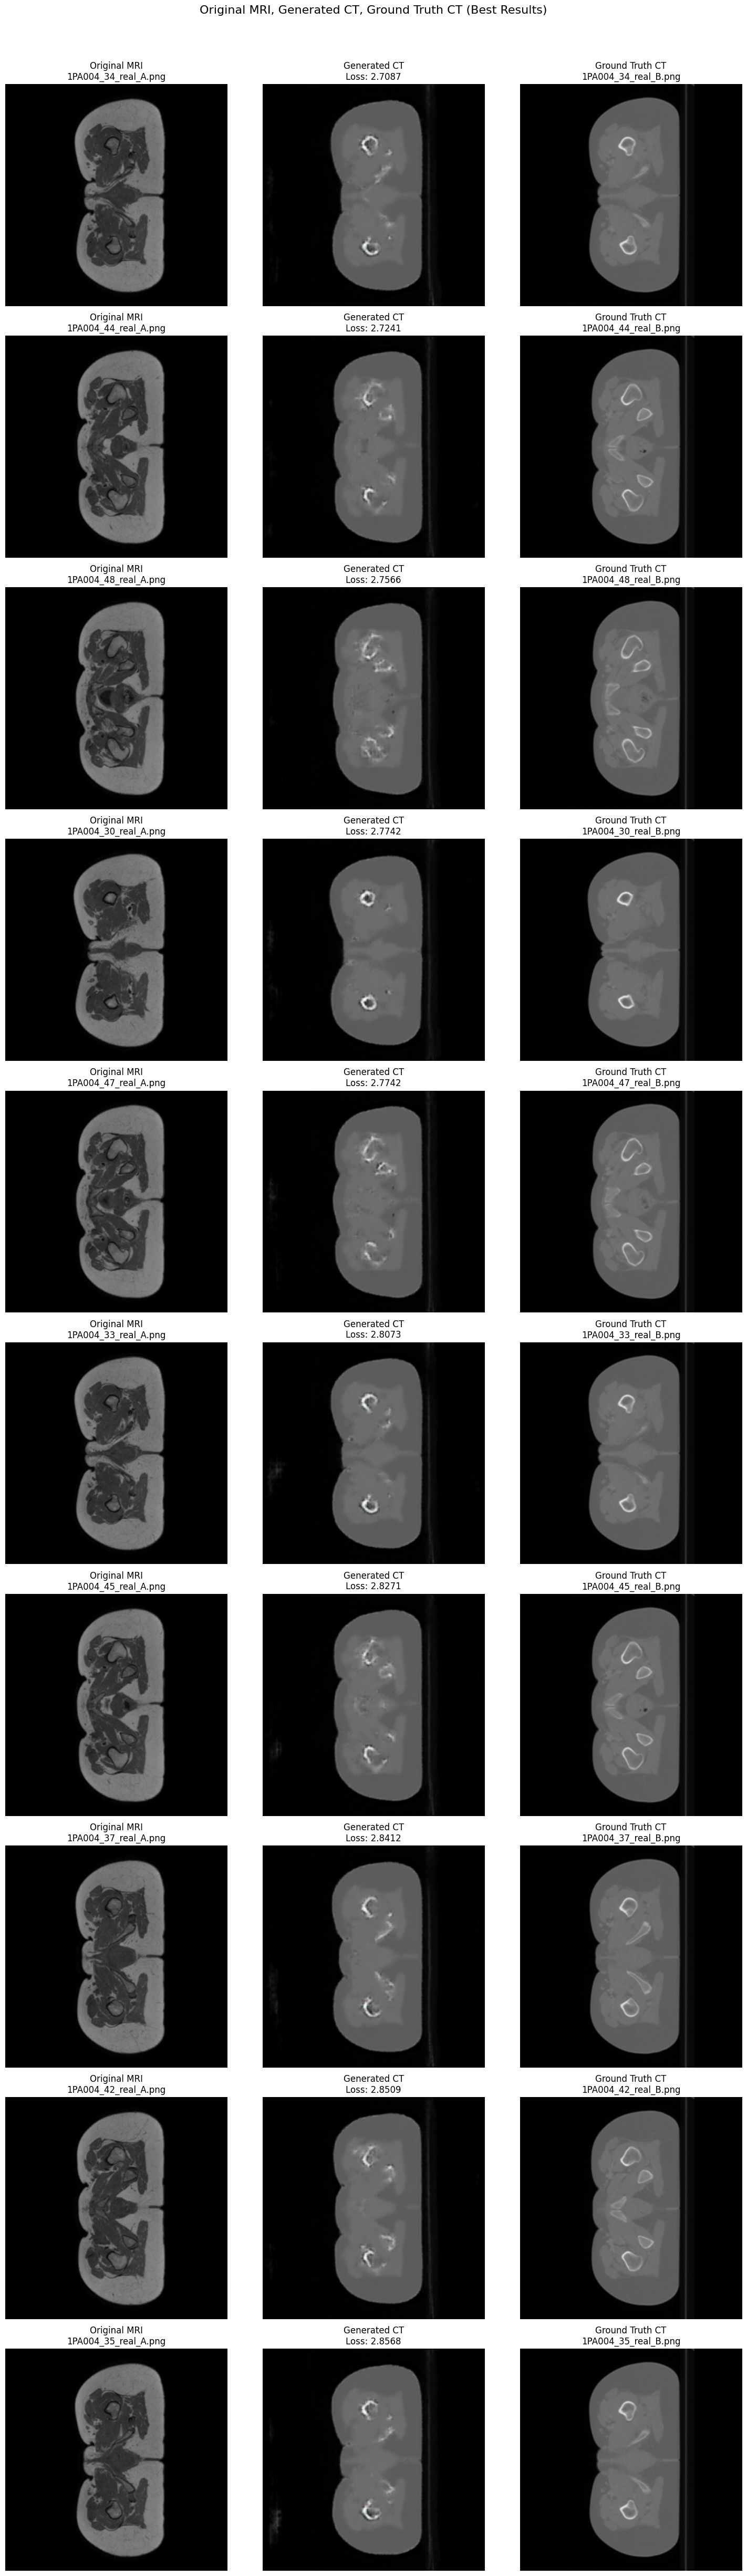

In [1]:
import os
import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np

# Path to the folder containing test results
results_folder = "./results/pix2pix_200_pair/test_latest/images"  # Update with your folder path

# Function to compute L1 loss between two images
def compute_l1_loss(img1, img2):
    img1_tensor = torch.tensor(np.array(img1), dtype=torch.float32)
    img2_tensor = torch.tensor(np.array(img2), dtype=torch.float32)
    return torch.nn.functional.l1_loss(img1_tensor, img2_tensor).item()

# Function to load and display the best 10 image pairs
def plot_best_image_pairs(results_folder, num_best=10):
    # List all files in the results folder
    all_files = [f for f in os.listdir(results_folder) if f.endswith(".png")]
    
    # Filter file types
    real_A_files = sorted([f for f in all_files if "real_A" in f])
    fake_B_files = sorted([f for f in all_files if "fake_B" in f])
    real_B_files = sorted([f for f in all_files if "real_B" in f])
    
    # Ensure we have matching file counts
    assert len(real_A_files) == len(fake_B_files) == len(real_B_files), "Mismatch in file counts!"
    
    # Compute L1 loss for each pair
    losses = []
    for i in range(len(fake_B_files)):
        fake_B_path = os.path.join(results_folder, fake_B_files[i])
        real_B_path = os.path.join(results_folder, real_B_files[i])
        
        fake_B = Image.open(fake_B_path).convert("L")  # Convert to grayscale if needed
        real_B = Image.open(real_B_path).convert("L")
        
        loss = compute_l1_loss(fake_B, real_B)
        losses.append((i, loss))  # Store index and loss
    
    # Sort by loss (ascending) and select the best pairs
    best_pairs = sorted(losses, key=lambda x: x[1])[:num_best]
    
    # Set up the plot
    fig, axes = plt.subplots(num_best, 3, figsize=(15, 5 * num_best))
    fig.suptitle("Original MRI, Generated CT, Ground Truth CT (Best Results)", fontsize=16)
    
    for i, (idx, loss) in enumerate(best_pairs):
        # Load images
        real_A_path = os.path.join(results_folder, real_A_files[idx])
        fake_B_path = os.path.join(results_folder, fake_B_files[idx])
        real_B_path = os.path.join(results_folder, real_B_files[idx])
        
        real_A = Image.open(real_A_path)
        fake_B = Image.open(fake_B_path)
        real_B = Image.open(real_B_path)
        
        # Plot images
        axes[i, 0].imshow(real_A, cmap="gray")
        axes[i, 0].set_title(f"Original MRI\n{real_A_files[idx]}")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(fake_B, cmap="gray")
        axes[i, 1].set_title(f"Generated CT\nLoss: {loss:.4f}")
        axes[i, 1].axis("off")
        
        axes[i, 2].imshow(real_B, cmap="gray")
        axes[i, 2].set_title(f"Ground Truth CT\n{real_B_files[idx]}")
        axes[i, 2].axis("off")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust title position
    plt.show()

# Call the function to plot the best images
plot_best_image_pairs(results_folder)



In [2]:
import os
import numpy as np
import nibabel as nib
from PIL import Image

# 設定 PNG 影像的存放資料夾
png_folder = "results/pix2pix_200_pair/test_latest/images"  # 請修改為你的資料夾路徑

print(f"共有 {len(os.listdir(png_folder))} 張影像")

# 只選擇含有 'fake_' 的影像，並以數字順序排序
png_files = sorted(
    [f for f in os.listdir(png_folder) if "fake_" in f],
    key=lambda x: int(x.split("_")[1])  # 依照檔名中的數字排序
)

# 檢查排序結果
print("排序後的影像列表：")
for f in png_files:
    print(f)

print(f"共有 {len(png_files)} 張影像")

# 讀取並轉換為 3D 陣列（轉為灰階）
image_slices = [np.array(Image.open(os.path.join(png_folder, f)).convert('L')) for f in png_files]
image_3d = np.stack(image_slices, axis=-1)  # 堆疊成 3D volume

# 設定 affine matrix（如果有原始的可以恢復）
affine = np.eye(4)

# 建立並儲存 NIfTI 影像
nii_image = nib.Nifti1Image(image_3d, affine)
nib.save(nii_image, "fake_images.nii")

print("轉換完成，輸出檔案：fake_images.nii")


共有 246 張影像
排序後的影像列表：
1PA004_10_fake_B.png
1PA004_11_fake_B.png
1PA004_12_fake_B.png
1PA004_13_fake_B.png
1PA004_14_fake_B.png
1PA004_15_fake_B.png
1PA004_16_fake_B.png
1PA004_17_fake_B.png
1PA004_18_fake_B.png
1PA004_19_fake_B.png
1PA004_20_fake_B.png
1PA004_21_fake_B.png
1PA004_22_fake_B.png
1PA004_23_fake_B.png
1PA004_24_fake_B.png
1PA004_25_fake_B.png
1PA004_26_fake_B.png
1PA004_27_fake_B.png
1PA004_28_fake_B.png
1PA004_29_fake_B.png
1PA004_30_fake_B.png
1PA004_31_fake_B.png
1PA004_32_fake_B.png
1PA004_33_fake_B.png
1PA004_34_fake_B.png
1PA004_35_fake_B.png
1PA004_36_fake_B.png
1PA004_37_fake_B.png
1PA004_38_fake_B.png
1PA004_39_fake_B.png
1PA004_40_fake_B.png
1PA004_41_fake_B.png
1PA004_42_fake_B.png
1PA004_43_fake_B.png
1PA004_44_fake_B.png
1PA004_45_fake_B.png
1PA004_46_fake_B.png
1PA004_47_fake_B.png
1PA004_48_fake_B.png
1PA004_49_fake_B.png
1PA004_50_fake_B.png
1PA004_51_fake_B.png
1PA004_52_fake_B.png
1PA004_53_fake_B.png
1PA004_100_fake_B.png
1PA004_101_fake_B.png
1PA004_102_

In [4]:
d = nib.load(r"pelvis_smalllll/1PA001/mr.nii.gz")
print(nii_image.shape)
print(d.shape)

(256, 256, 119)
(565, 338, 146)
